# Working out if we can tractably perform optimality experiments with the effective radius of a knn graph vs. number of samples vs. testing out if we get an interesting probability.

Given runtime (and sometimes space) constraints on compute cluster, we can only build knn-graphs with ~500 neighbors (see notes on some quick `kgraph` tests).

This notebook is to do some sanity experiments and calculations to ensure that these experiments are runnable. We do the following:

- [x] Graph/table the Sauer-Shelah bound curve to see how many samples are required to hit certain probabilities.  

- [x] Run the KNN version of the PRM a certain number of times to determine the concentration of the effective connection radius for varying numbers of sampling (in the exact environment we intend to run them in).
- [x] Test out version of the bounds that use tighter techniques (e.g. Chernoff, Lipschitz-type geometric concentration)

We'll compare these results and draw some conclusions at the end of the document.

In [1]:
%cd ~/Research/nonasymptotic-mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

plt.rcParams.update({"text.usetex": True})

from nonasymptotic.bound import *
from nonasymptotic.envs import StraightLine, NarrowPassage

seed = 1999

/home/seiji/Research/nonasymptotic-mp


Dimensions correspond with common robot DofS (planar, planar + angle, arm on base, two arms, PR2).

In [2]:
# Specify the dimensions and sample counts we intend to test (only add in the 1e5/1e6 if we run this on supercloud).
ds = np.array([2, 3, 6, 7, 10, 14, 20])
sample_counts = np.array([1e2, 1e3, 1e4], dtype=np.int32)  # int(1e5), int(1e6) 

We'll be conducting these sanity-checking experiments in the exact environment we'll be evaluating them in: simple box environments $[-0.5, 1.5] \times [-0.5, 0.5]^{d-1}$, (we chose $\delta = 0.5$ so that the volume of the whole environment does not change between dimensions).

In [3]:
# construct environments
clearance = 0.5
envs = [StraightLine(_d, clearance, length=2.0, seed=seed) for _d in ds]

Since these are optimality experiments, we should get a numerical sense of the $\epsilon \mapsto r_{conn}$ mapping. It is important to note that we lose 1-to-1 mapping when we shoot past 1 ($\epsilon$ is really only meant to be small, e.g. $<1$), so that's why we do this range. 

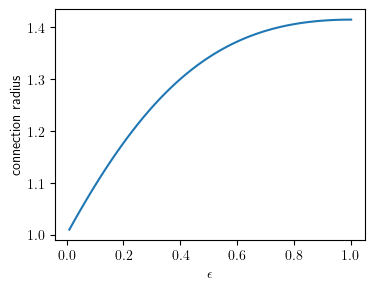

In [4]:
tols = np.linspace(1.0, 0.01, num=100)
conn_rads = compute_connection_radius(clearance, tols)

plt.figure(figsize=(4, 3))
plt.plot(tols, conn_rads)
plt.xlabel('$\epsilon$')
plt.ylabel('connection radius')
plt.show()

So we're looking to have connection radii between the $[1, \approx 1.4]$ range. But really, if the (effective) connection radius, we're in trouble.

Next, we'll zoom in on the kinds of $\epsilon$-nets we need to have, and how many samples (as predicted by Sauer-Shelah) we need to hit them (with an interesting range of hittable probabilities).

First (since this is a dimension-free quantity) -- the radius of the balls on the $\epsilon$-nets.

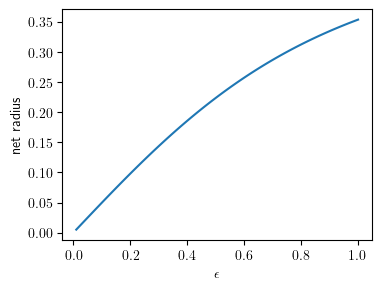

In [5]:
net_rads = compute_epsilon_net_radius(clearance, tols)

plt.figure(figsize=(4, 3))
plt.plot(tols, net_rads)
plt.xlabel('$\epsilon$')
plt.ylabel('net radius')
plt.show()

This looks tiny... a bit worried here. But we press on to find out.

We first compute the required rhos for each dimension, and then we zoom in (interesting ranges) of Sauer-Shelah.

verify checks scale to higher dimensions tooSince the relationship between conn_rad and the net size is linear with $\delta$, we don't need to plot them as we did with $\epsilon$. 

We'll just skip to plotting the $\rho$-volumes we need to hit.

<Figure size 640x480 with 0 Axes>

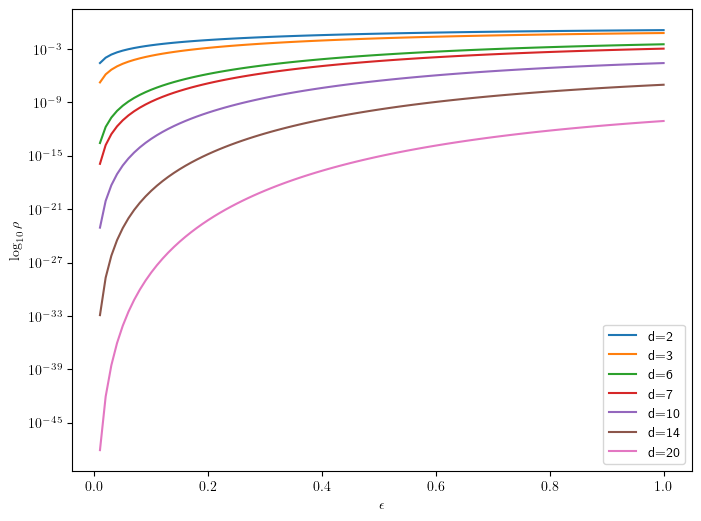

In [6]:
vols_env = np.array([_e.volume for _e in envs])

# we could probably vectorize in a meshgrid, but for sanity, we just do dimension-by-dimension

rhos = []
for _d, _vol_env in zip(ds, vols_env):
    rhos.append(compute_rho(clearance, tols, _d, _vol_env))

rhos = np.array(rhos)

plt.figure()
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylabel('$\log_{10} \\rho$')
for _rhos_d, _d in zip(rhos, ds):
    ax.plot(tols, _rhos_d, label='d={}'.format(_d))

ax.set_xlabel('$\epsilon$')
ax.set_yscale('log')
plt.legend()
plt.show()

## VC/Sauer-Shelah bound, plotted at last
Plotting the required samples at different probability bands (objective 1!).

In [7]:
# computing and plotting the interesting ranges of Sauer-Shelah for each dimension
# indexing layout of the record array: [success_probs] X [epsilons<->rho] -> sample_required

def _partition_curves_into_equal_chunks(_x_indices, _y_curves, n_chunks=5):
    _n_points = len(_x_indices)
    _nominal_length = np.floor(_n_points / n_chunks).astype('int')

    # include extra bits into the first chunks, because that's where the least increase happens
    #   so influences the plot yscale the easiest
    _extra_length = _n_points - _nominal_length * n_chunks

    _domains = []
    _ranges = []

    _cur_i = _nominal_length + _extra_length
    _domains.append(_x_indices[:_cur_i])
    _ranges.append(_y_curves[:, :_cur_i])

    for _i in range(1, n_chunks):
        _next_i = _cur_i + _nominal_length

        _domains.append(_x_indices[_cur_i:_next_i])
        _ranges.append(_y_curves[:, _cur_i:_next_i])

        _cur_i = _next_i

    return _domains, _ranges


def _initialize_plot_for_curve_ranges(_data_domains, _data_ranges, _range_labels):
    _n_plots = len(_data_ranges)
    fig, axes = plt.subplots(nrows=_n_plots, ncols=1, figsize=(5, 4 * _n_plots))

    if _n_plots == 1:
        axes = [axes]

    for _i_ax, _ax in enumerate(axes):
        for _i_rl, _rl in enumerate(_range_labels):
            _ax.plot(_data_domains[_i_ax], _data_ranges[_i_ax][_i_rl, :], label='p=%f' % _rl)

        _ax.legend()

    return fig, axes


def _batch_net_search(_ds, _sps, _param, _hit_vols, vol_thresh=1e-12):
    _required_samples = np.zeros((len(_ds), len(_sps), len(_param)))
    _required_samples[:, :, :] = np.nan
    # (the bound computation is woefully unvectorized, which is why we have to do this)
    for i_d, _d in enumerate(_ds):
        print('computing %i' % _d)
        _vc = _d + 1
        for i_sp, _sp in enumerate(_sps):
            for i_rho, _rho in enumerate(_hit_vols[i_d]):
                # print('rho: %.16f' % _rho)
                if _rho < vol_thresh:
                    continue

                _required_samples[i_d, i_sp, i_rho] = doubling_sample_search_over_log2_prob_bound(
                    (lambda _m: compute_sauer_shelah_bound_log2(_m, _rho, _vc)), _sp)
        print('finished %i' % _d)
    return _required_samples


Python computation slows down with $\rho \lessapprox 1\mathrm e -10$. 

computing 2
finished 2
computing 3
finished 3
computing 6
finished 6
computing 7
finished 7
computing 10
finished 10
computing 14
finished 14
computing 20
finished 20


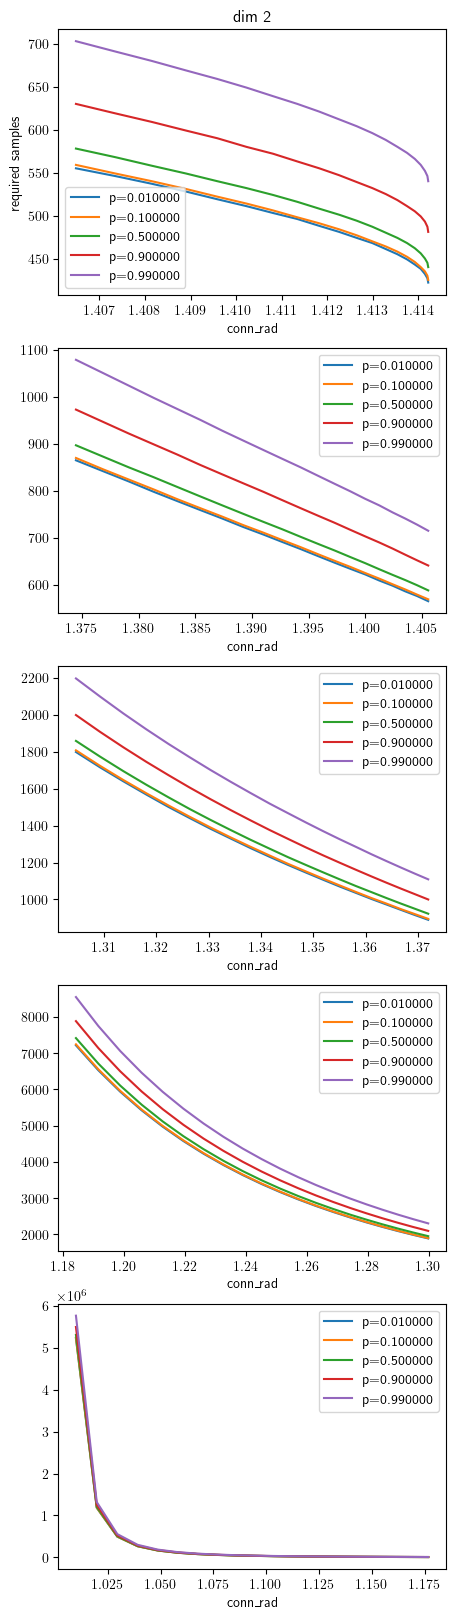

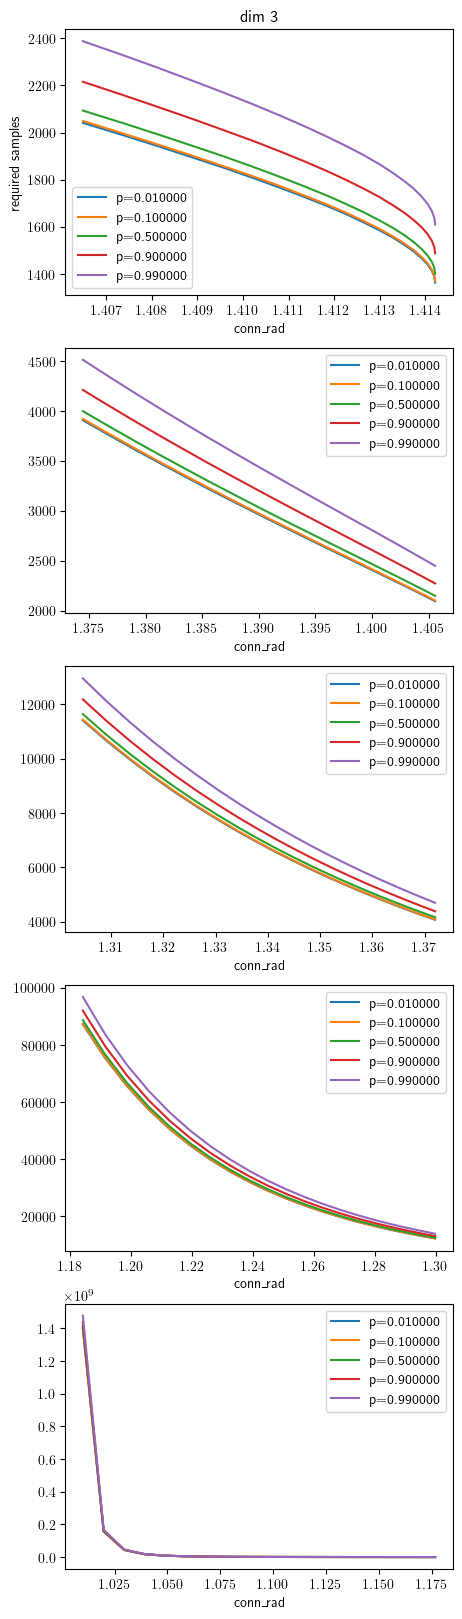

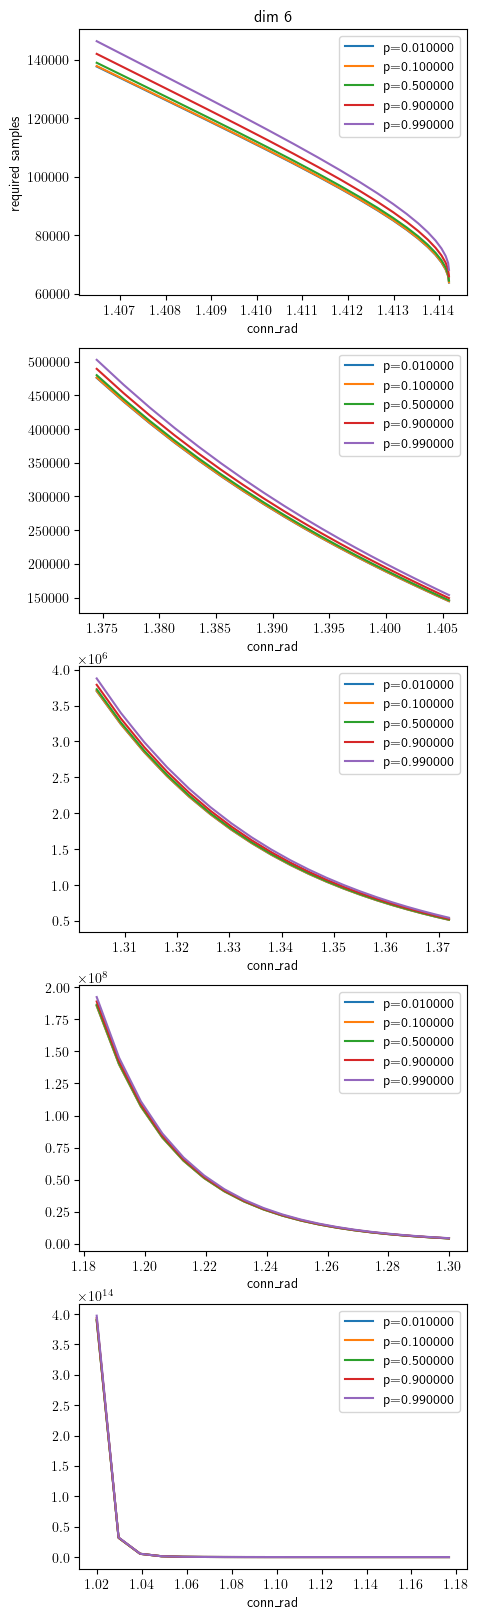

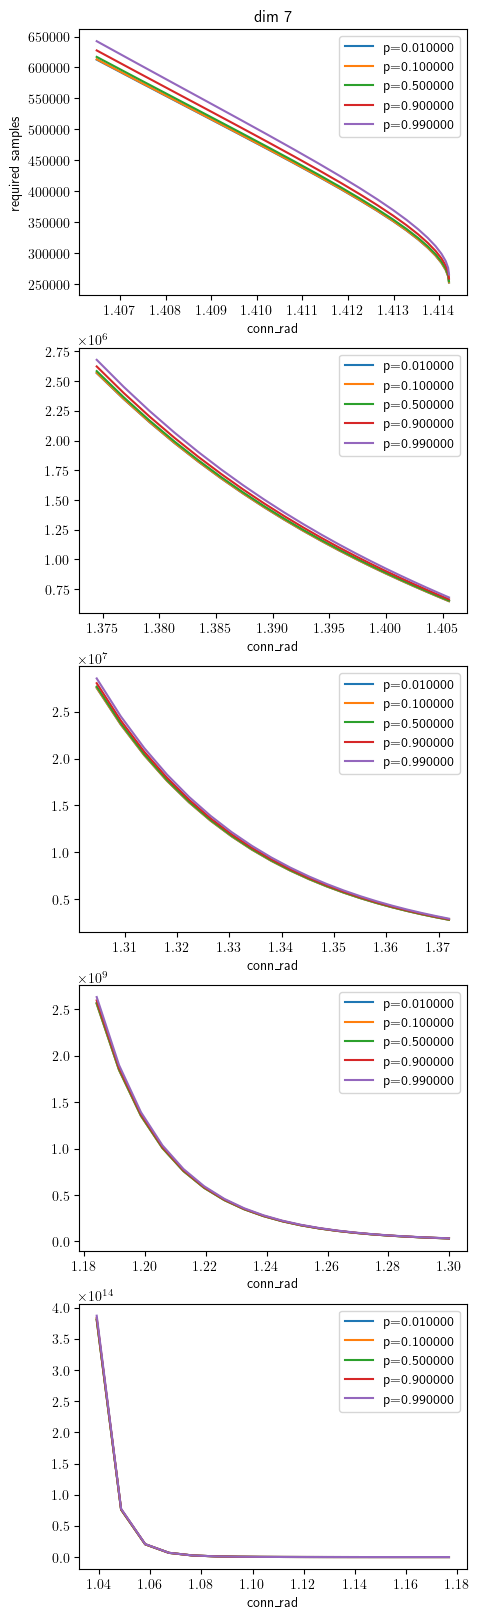

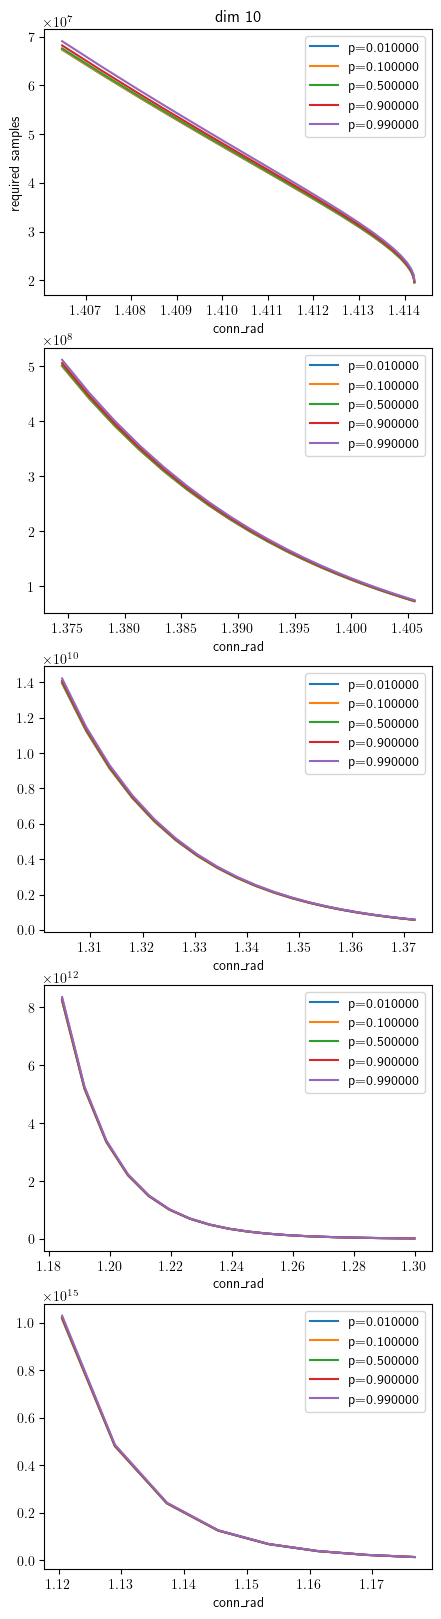

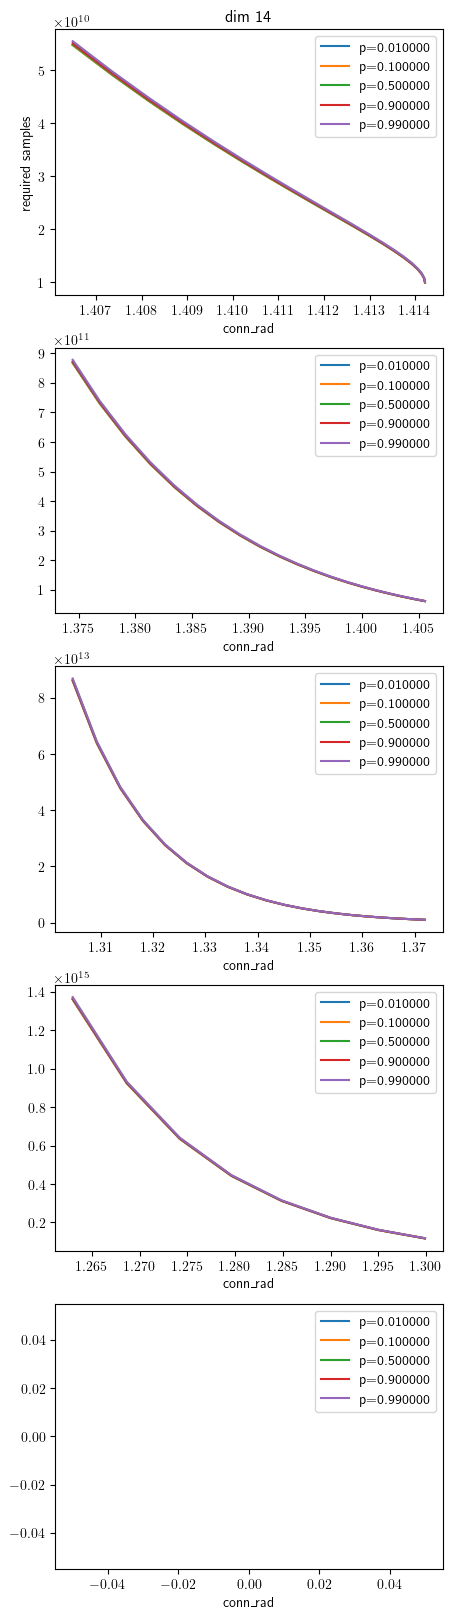

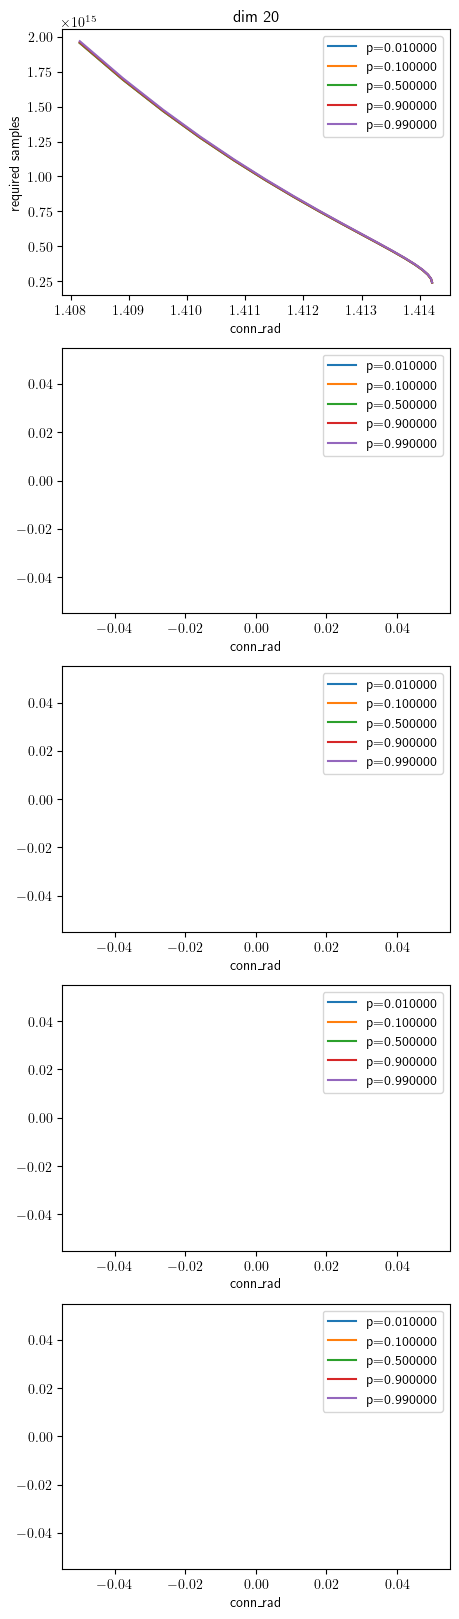

In [8]:
rho_thresh = 1e-12
success_probs = np.array([1e-2, 0.1, 0.5, 0.9, 0.99])

required_samples = _batch_net_search(ds, success_probs, tols, rhos, vol_thresh=rho_thresh)

for _rs, _d in zip(required_samples, ds):
    domain_chunks, range_chunks = _partition_curves_into_equal_chunks(conn_rads, _rs)
    _, axes = _initialize_plot_for_curve_ranges(domain_chunks, range_chunks, success_probs)
    [ax.set_xlabel('conn_rad') for ax in axes]
    axes[0].set_ylabel('required samples')
    axes[0].set_title('dim %i' % _d)
    plt.show()


## Clearance Calculations.

Here, we pre-compute the desired experimental parameters for the generalized narrow passage/hallway problem for high dimensions.

The $(\delta, \infty)$ kicks in when the net has radius $\delta/4$ and the connection radius is of size $2\delta$.

In [9]:
clearances = np.linspace(0.1, 0.5, num=100)

<Figure size 640x480 with 0 Axes>

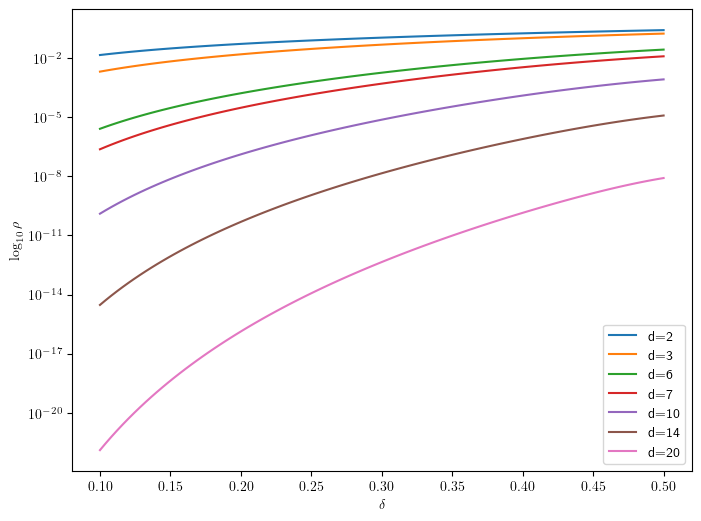

In [10]:
narrow_envs = [[NarrowPassage(_d, _c, seed) for _c in clearances] for _d in ds]
narrow_rhos = [[compute_rho(clearances[i_c], None, ds[i_d], narrow_envs[i_d][i_c].volume)
                for i_c in range(len(clearances))]
               for i_d in range(len(ds))]

plt.figure()
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylabel('$\log_{10}\\rho$')
for _i_d, _d in enumerate(ds):
    ax.plot(clearances, narrow_rhos[_i_d], label="d={}".format(_d))

ax.set_xlabel("$\delta$")
ax.set_yscale('log')
plt.legend()
plt.show()

And now, the numerical Sauer-Shelah results.

computing 2
finished 2
computing 3
finished 3
computing 6
finished 6
computing 7
finished 7
computing 10
finished 10
computing 14
finished 14
computing 20
finished 20


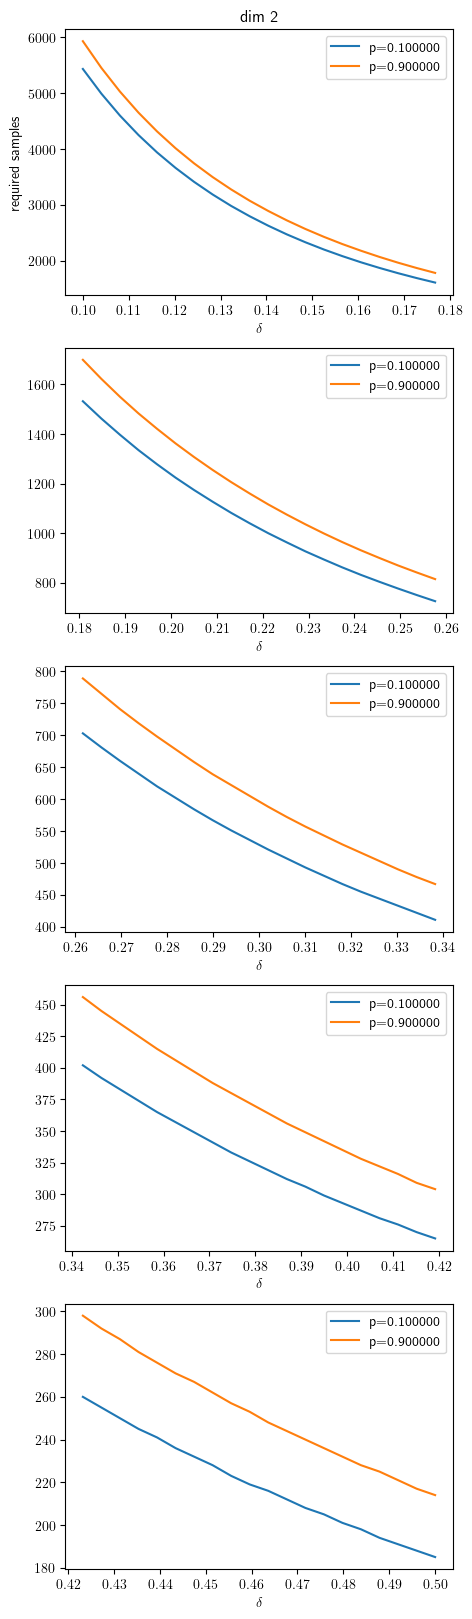

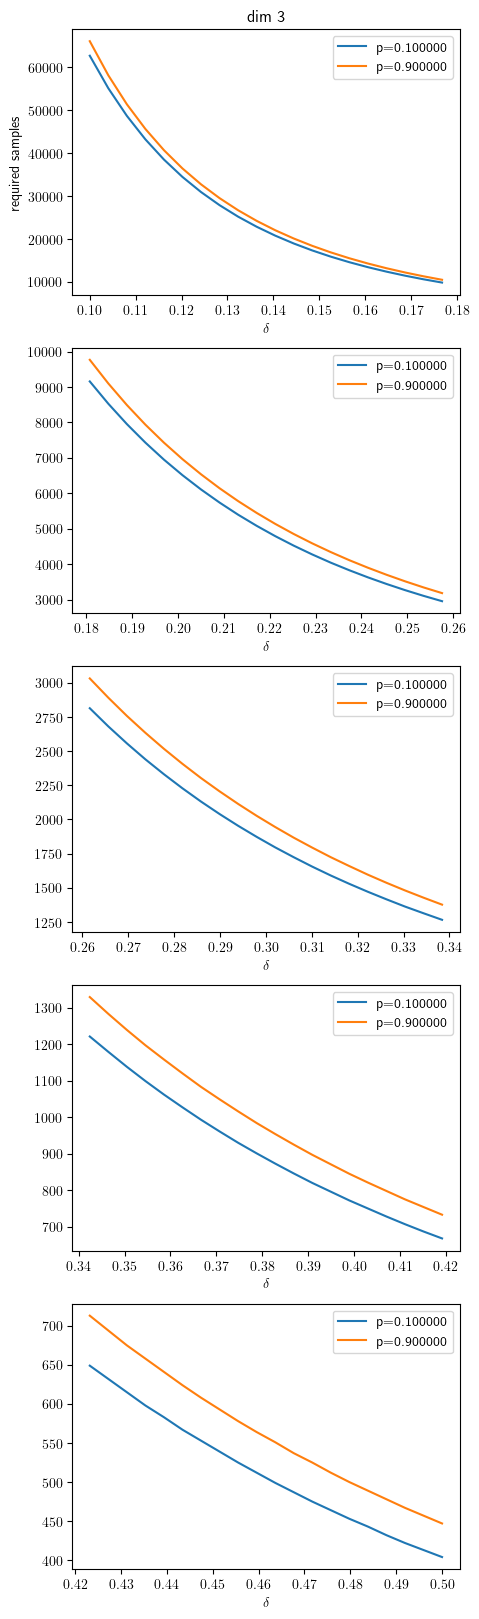

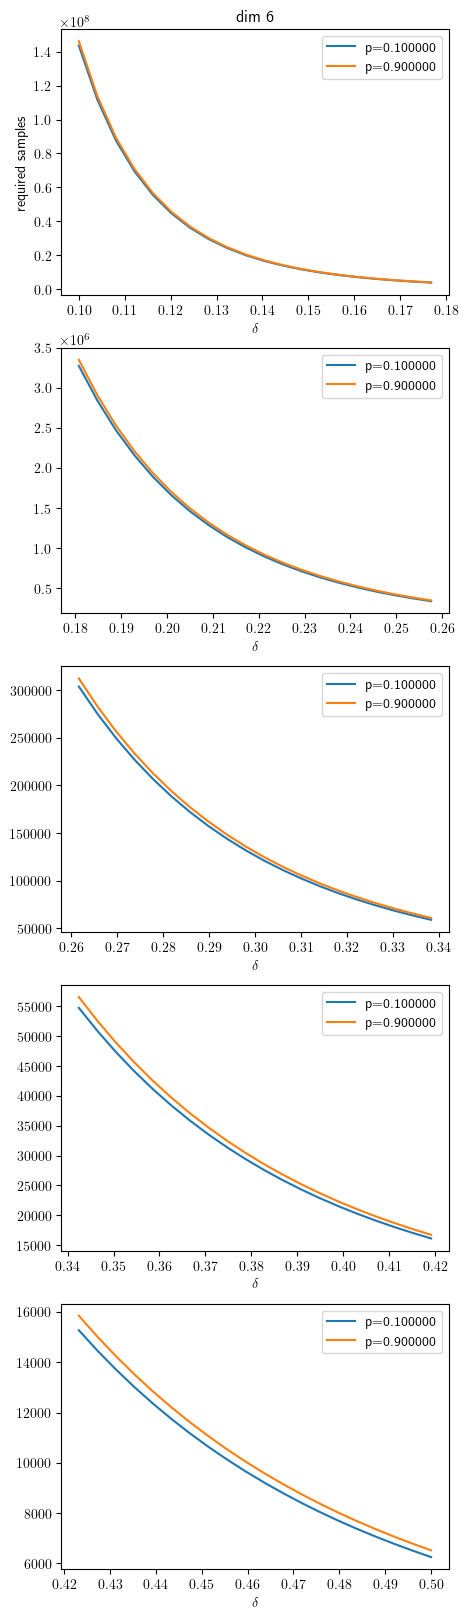

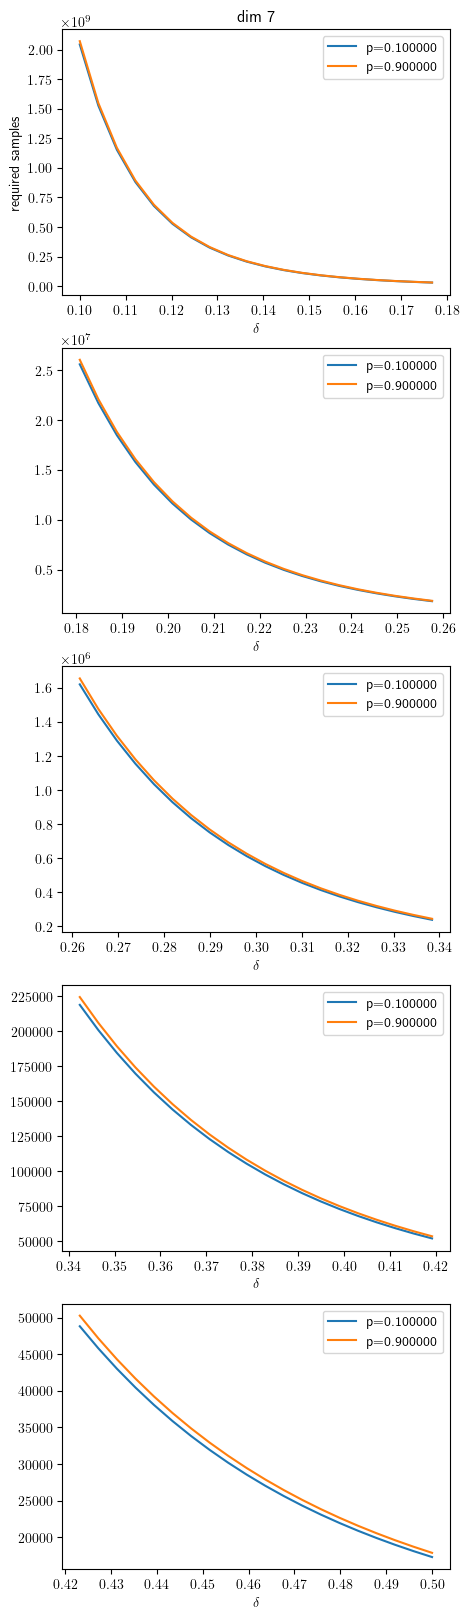

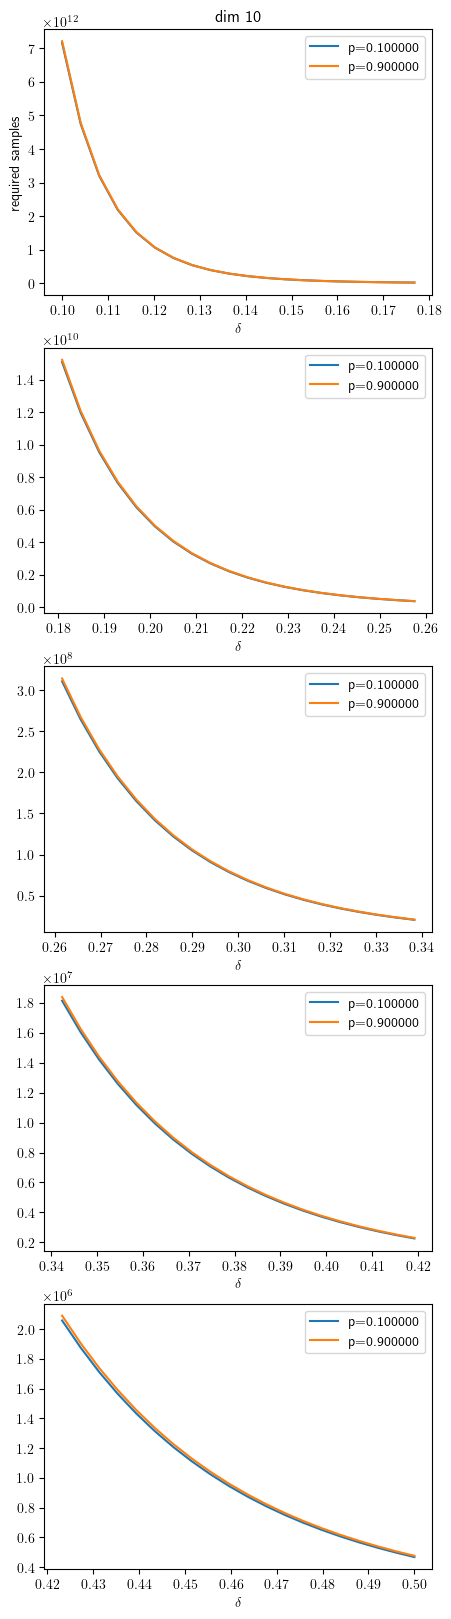

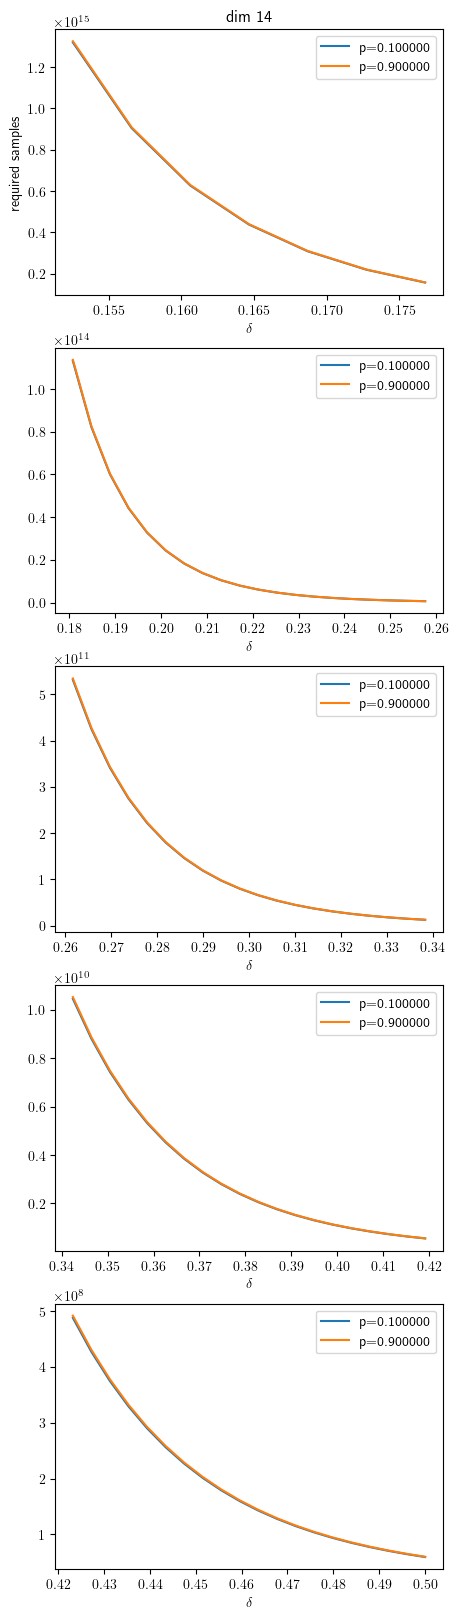

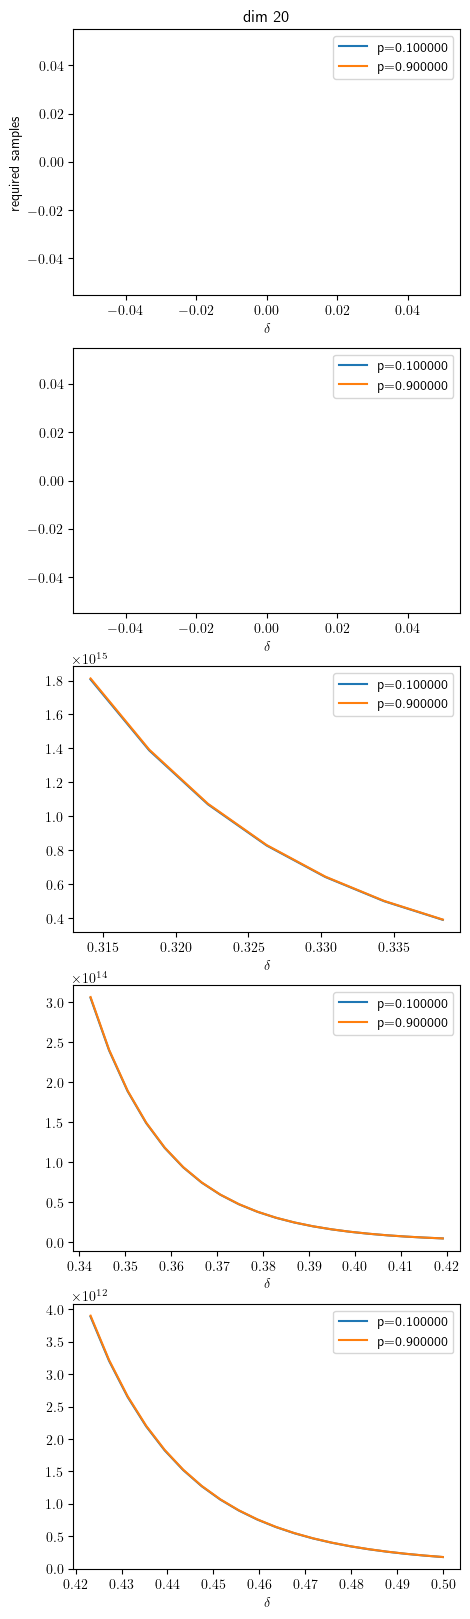

In [11]:
success_probs = np.array([0.1, 0.9])
rho_thresh = 1e-12

required_samples = _batch_net_search(ds, success_probs, clearances, narrow_rhos, vol_thresh=rho_thresh)

for _rs, _d in zip(required_samples, ds):
    domain_chunks, range_chunks = _partition_curves_into_equal_chunks(clearances, _rs)
    _, axes = _initialize_plot_for_curve_ranges(domain_chunks, range_chunks, success_probs)
    [ax.set_xlabel('$\delta$') for ax in axes]
    axes[0].set_ylabel('required samples')
    axes[0].set_title('dim %i' % _d)
    plt.show()

## Empirical Concentration Experiments on NN Radii

Next, empirically look at the `effective' connection radius of nearest neighbor graphs with a varying number of neighbors. We'll set a number of iterations and than histogram them out, for each iteration.

Note: this is really just plotting code for a cluster run (see `run_knn_radius_trial.py`).

In [12]:
# load in and aggregate results
import json
from itertools import product
def _exp_name_to_df(_en):
    out_dirs = glob.glob(os.path.join('exps', 'results', _en, 'out*.csv'))
    out_dfs = [pd.read_csv(_od, index_col=0) for _od in out_dirs]
    return pd.concat(out_dfs, axis=0)

def _exp_name_to_dims_count_knn(_en):
    config_path = os.path.join('exps', 'results', _en, 'config.json')
    config = json.load(open(config_path, 'r'))
    return config['dims_to_test'], config["sample_schedule"], config["neighbor_schedule"]

def _exp_name_to_radius_df(_en, _p=0.95):
    _record = []
    _ds, _ns, _ks = _exp_name_to_dims_count_knn(_en)
    for _d, _n, _k in product(_ds, _ns, _ks):
        if _n < _k: #or _n < 10000: #or _d != 6:
            continue
            
        _env_idx = np.searchsorted(ds, _d, side='left')
        bound_rad = halving_radius_search_over_log_prob_bound(
            lambda _r: compute_tail_knn_radius_log_prob_chernoff_kl(_n, _k, _r, _d, vols_env[_env_idx]),
            0.01,
            1.4,
            _p,
            tol=1e-6
        )
        _record.append((_d, _n, _k, bound_rad)) 
    
    return pd.DataFrame(_record, columns=['dim', 'n_samples', 'n_neighbors', 'eff_rad'])


<Figure size 640x480 with 0 Axes>

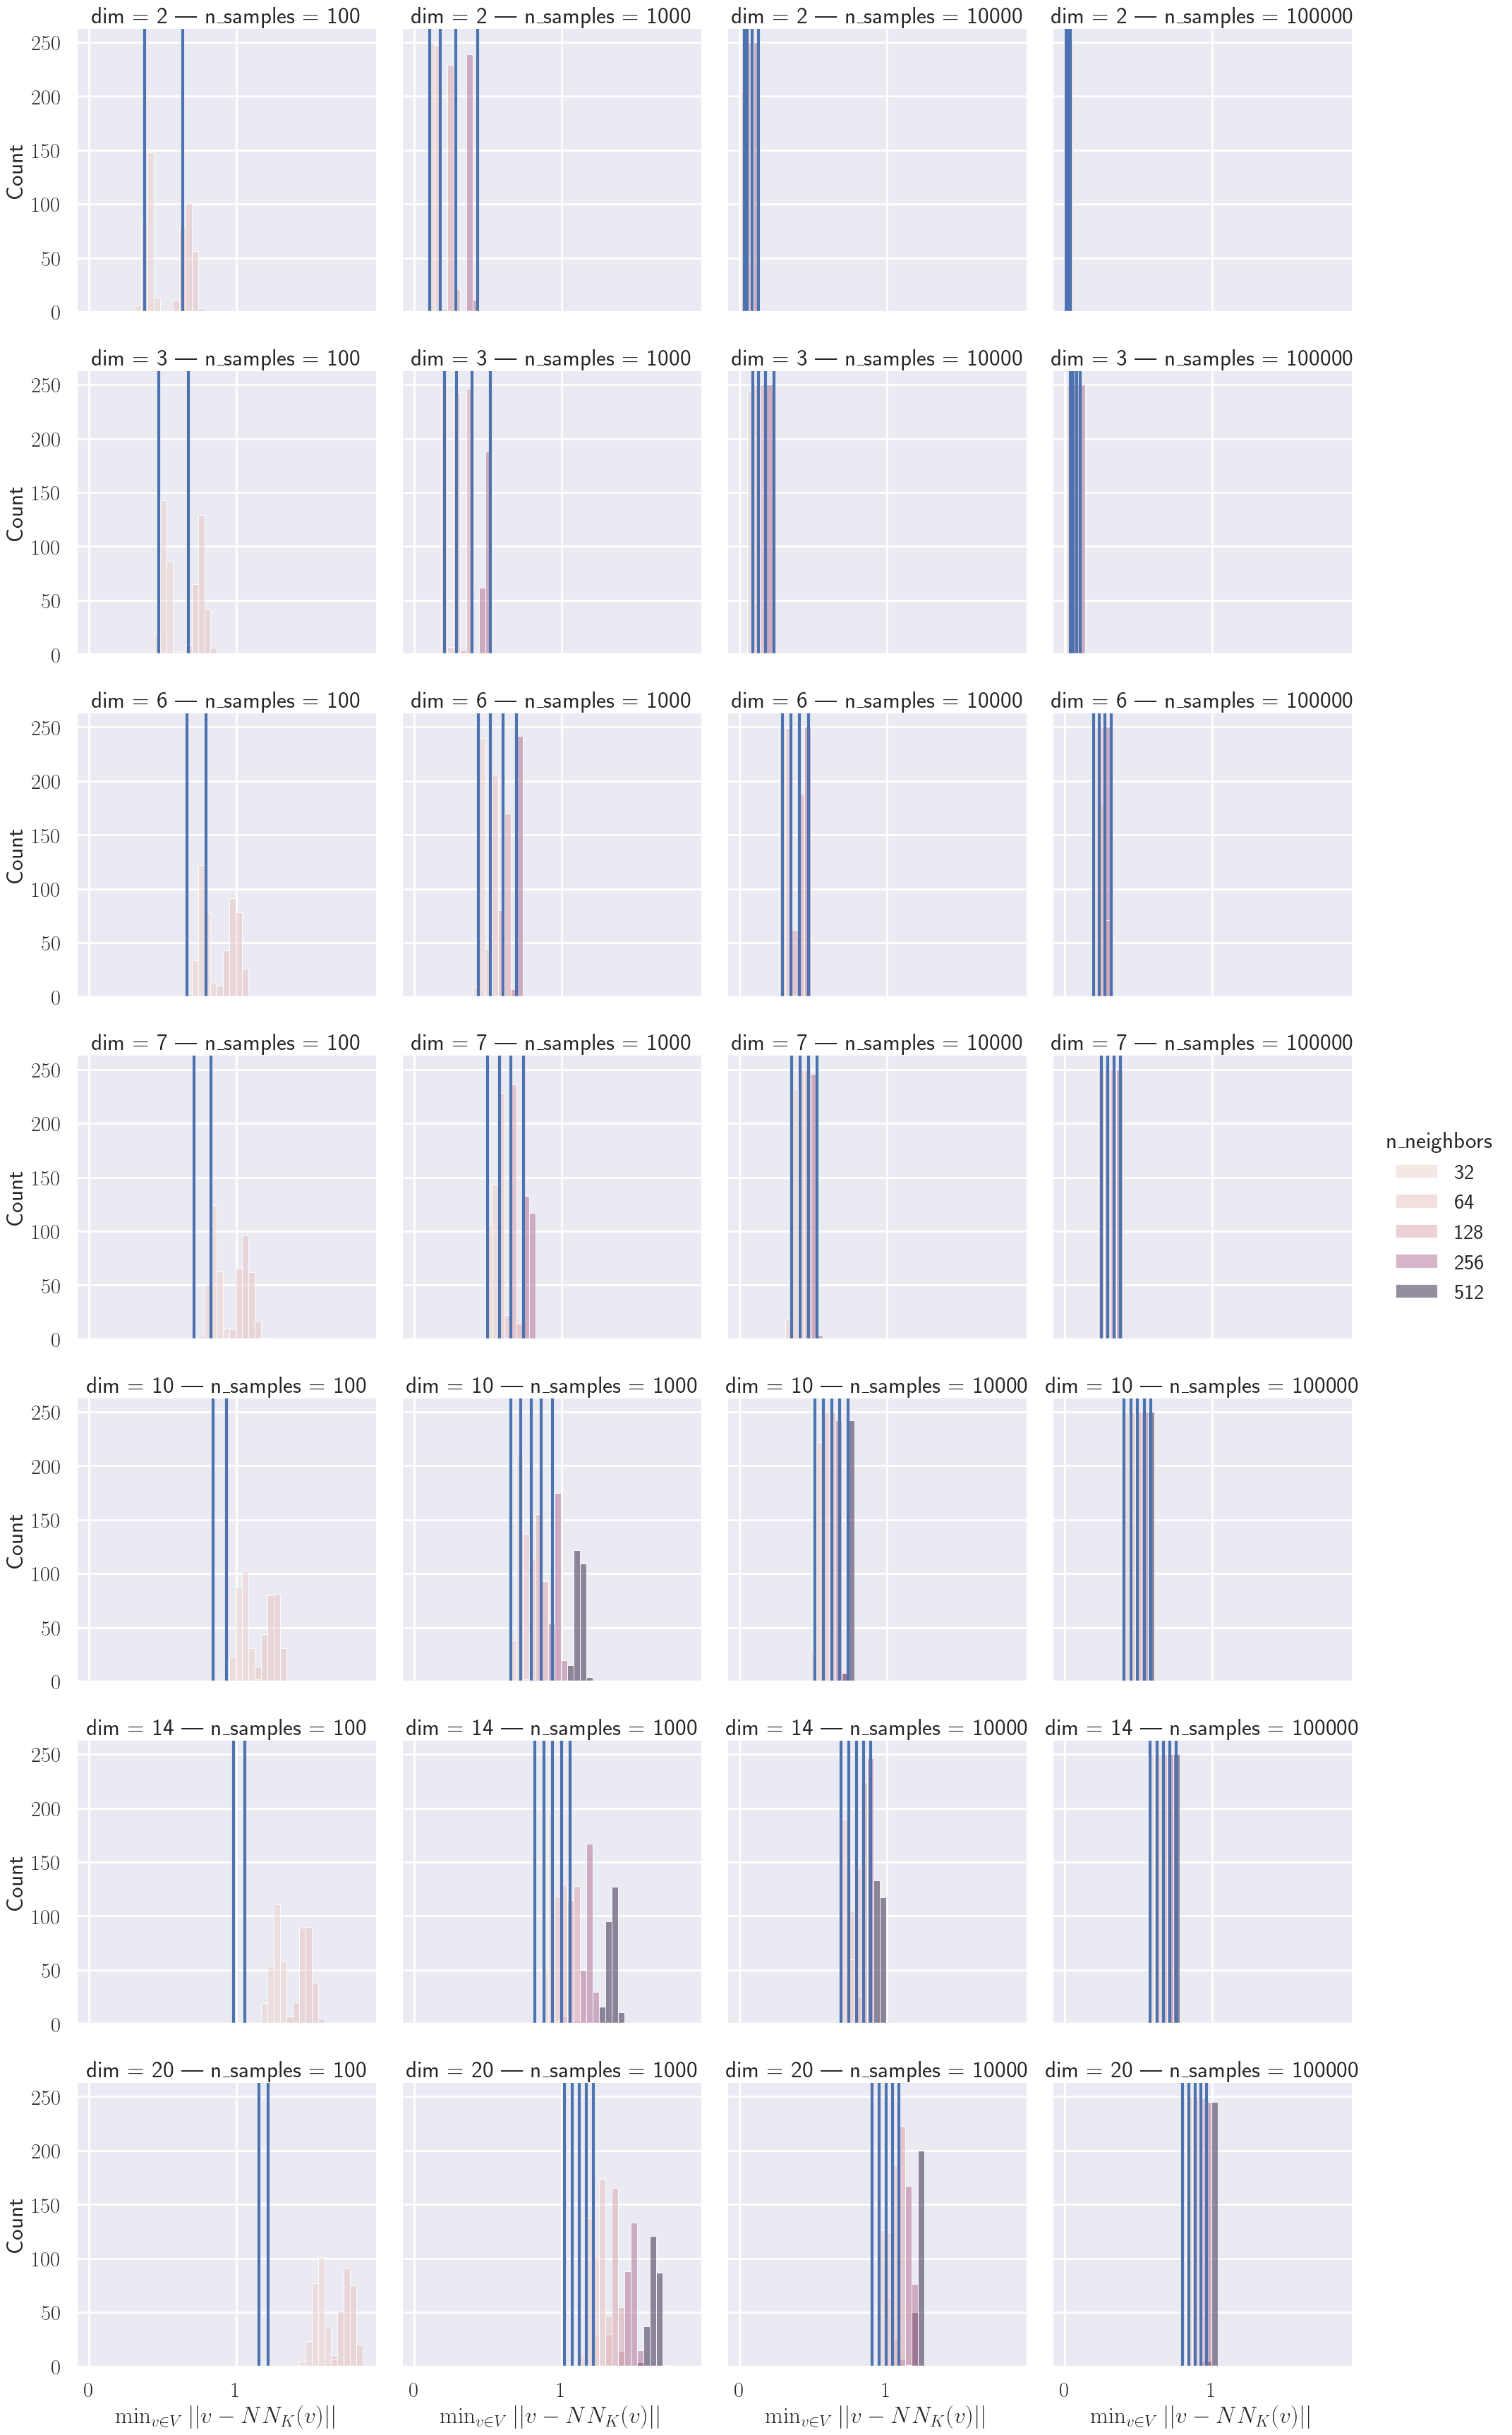

In [13]:
exp_name_1 = 'knn_low_dim_run1_20240501-014835'
empirical_df_1 = _exp_name_to_df(exp_name_1)
bound_rads_df_1 = _exp_name_to_radius_df(exp_name_1, _p=0.99)

exp_name_2 = "knn_high_dim_run0_20240506-202400"
empirical_df_2 = _exp_name_to_df(exp_name_2)
bound_rads_df_2 = _exp_name_to_radius_df(exp_name_2, _p=0.99)

big_empirical_df = pd.concat([empirical_df_1, empirical_df_2], axis=0)
big_empirical_df = big_empirical_df[big_empirical_df['n_samples'] <= 100000]
big_bound_rads_df = pd.concat([bound_rads_df_1, bound_rads_df_2], axis=0)

plt.figure()
sns.set_theme(style="darkgrid", context='poster')
sns.color_palette('colorblind')
g = sns.displot(
    big_empirical_df, x="eff_rad", row="dim", col="n_samples", hue='n_neighbors',
)
# couldn't get the refline to work, so doing a hacky thing, should be handled by displot
for _, _rec in big_bound_rads_df.iterrows():
    try:
        g.axes_dict[(_rec['dim'].astype(int), _rec['n_samples'].astype(int))].axvline(_rec['eff_rad'])
    except KeyError:
        continue

for bot_axs in g.axes[-1]:
    bot_axs.set_xlabel('$\min_{v \in V} ||v - NN_K(v)||$')
plt.show()


# bound_rads_df = _exp_name_to_radius_df(exp_name, _p=0.95)
# big_out_df = _exp_name_to_df(exp_name)
# big_out_df = big_out_df[big_out_df['n_samples'] < 1000000]
# plt.figure()
# sns.set_theme(style="darkgrid", context='poster')
# sns.color_palette('colorblind')
# g = sns.displot(
#     big_out_df, x="eff_rad", row="dim", col="n_samples", hue='n_neighbors'
# )
# for _, _rec in bound_rads_df.iterrows():
#     try:
#         g.axes_dict[(_rec['dim'].astype(int), _rec['n_samples'].astype(int))].axvline(_rec['eff_rad'])
#     except KeyError:
#         continue
# plt.show()


## Conclusion 

For tractability reasons the `effective` radius shrinks way too fast to satisfy the conditions that we were hoping to assume to directly apply the binary search trick in the paper. Even for $d=20$ at 1 000 000 samples. Unfortunate.

To make sure these experiments run in a timely manner (e.g. so we hit May 31 2024 WAFR), we need to make some concessions and introduce a gap between theory and practice.

Options:
- Drop the fancy radius binary search (since we loose our estimate of what $\epsilon$ may be and just do some straight MC (which may take a while, but `kgraph` may help?
- Prove the knn bound and then use it to set the effective $\delta$ in the hypothesis of the main theorem. Then we can do the binary search.
- Move away from knn constructions of the graph to begin with (our adjacency data is extra!). Use an implicit representation and use either (worst case linear) or knn search for the "neareness."
    - Use radix bucketting trick (see if it will scale)?  

Using small numerical schemes doesn't seem to be working out. So maybe we'll try tail bounding for a bit.

We'll try to do the result using a simple Hoeffding-type union bound.
We test tightness by just plotting an hline at the high probability mark (and hopefully, they will be distinguishable per clump).

## Addendum: comparing KNN radius decay rate to the number of sample required to find an net with some prob.

A worry is that the effective connection radius _may_ decay faster than the number of samples required to find the radius of the 
corresponding net.

This figure is here to apply the numerical bounds to see if this is actually true. We believe so;
the numerical bound for the radius decay is derived using a loose union bound.

This bound is plotted in the setting of the unit cube.

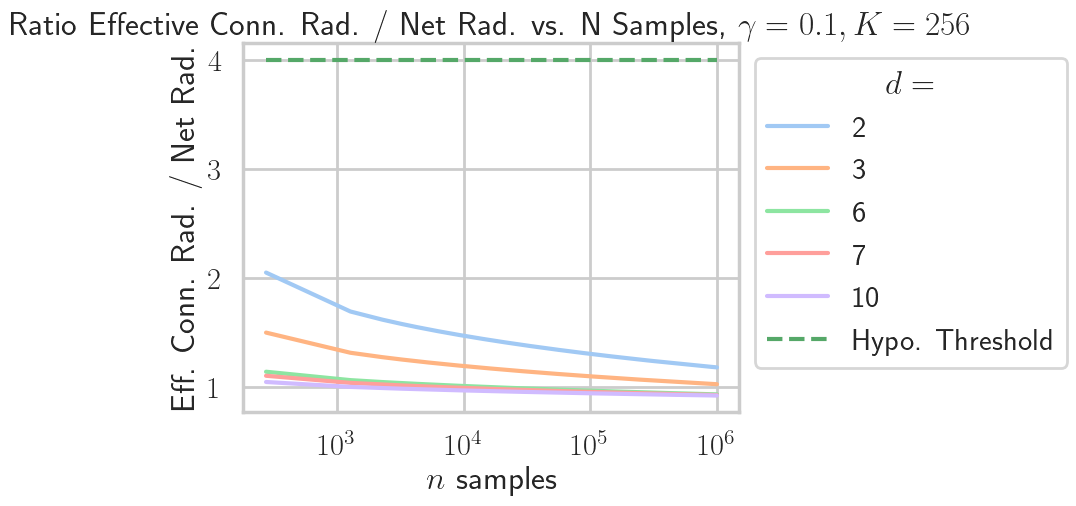

In [19]:
# first, fix failure probability, maximum n samples, and K in knn
# this computation is done in the unit cube.
failure_prob = 0.1
max_samples = int(1e6)
n_samples = np.arange(275, max_samples + 2, step=1000)
k = 256

_ds = ds[:5]
smallest_net_rads = np.zeros((n_samples.size, _ds.size))
largest_conn_rads= np.zeros((n_samples.size, _ds.size))

## both net-radius and knn radius needs to be done per-sample, since ss_sum is not ufunc'ed.
for _is, _n_sample in enumerate(n_samples):
    for _id, _d in enumerate(_ds):
        # print('procssing: %i, %i' % (_n_sample, _d))
        smallest_net_rads[_is, _id] = compute_net_radius_from_prob(_d, _n_sample, failure_prob, vol_env=1.0)
        largest_conn_rads[_is, _id] = halving_radius_search_over_log_prob_bound(
            lambda _r: compute_tail_knn_radius_log_prob_chernoff_kl(_n_sample, k, _r, _d, vol_env=1.0, enable_union_bound_factor=True),
            1e-10,
            np.sqrt(20),
            1 - failure_prob
        )
        
# next, we find the ratio between these two:
rads_ratio = largest_conn_rads / smallest_net_rads

# and we load them up in a dataframe and plot them against the hypothesis
# threshold (ratio >= 4)
mi = pd.MultiIndex.from_product([n_samples, _ds], names=['n_samples', 'ds'])
rat_df = pd.DataFrame(data=rads_ratio.flatten(order='C'), index=mi, columns=['ratio']).reset_index()
        
sns.set_theme(style='whitegrid', context='poster')
ax = sns.lineplot(data=rat_df, x='n_samples', y='ratio', hue='ds', palette='pastel')
ax.hlines(y=4, xmin=n_samples[0], xmax=n_samples[-1], linestyles='--', label='Hypo. Threshold', color='g')
ax.set_xscale('log')
ax.set_title('Ratio Effective Conn. Rad. / Net Rad. vs. N Samples, $\gamma=0.1,K=256$')
ax.set_ylabel('Eff. Conn. Rad. / Net Rad.')
ax.set_xlabel('$n$ samples')
ax.legend().set_title('$d=$')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.0, 1))
plt.savefig('eff_rad_rat.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [29]:
dir(ax.hlines)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__signature__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__wrapped__']

In [ ]:
# # zombie code (may come back again!)

# def _partition_curves_into_readable_ranges(_xindices, _ycurves, thresh=1e3):
#     # we operate on the last curve, since it's set up to be the most extreme
#     # we also assume that curves are in ascending order (tol goes down... rho goes down... 
#     #   number of samples goes up)
#     assert _ycurves.shape[1] == len(_xindices)
# 
#     _data_domains = []
#     _data_ranges = [] 
# 
#     _i = 0
#     while True:
#         _i_val = _ycurves[-1, _i]
#         _ip1 = np.searchsorted(_ycurves[-1, :], _i_val + thresh, side='right')
# 
#         _data_ranges.append(_ycurves[:, _i:_ip1])
#         _data_domains.append(_xindices[_i:_ip1])
# 
#         if _ip1 >= _ycurves.shape[1] - 1:
#             return _data_domains, _data_ranges
# 
#         _i = _ip1 
# 
# 
# def _compute_samples_per_success_probs_and_tols(_d, _sps, _rhos):
#     _required_samples = np.zeros((len(_sps), len(_rhos)))
# 
#     _vc = _d + 1
#     for i_sp, _sp in enumerate(_sps):
#         for i_rho, _rho in enumerate(_rhos):
#             _required_samples[i_sp, i_rho] = doubling_search_over_sauer_shelah(_rho, _vc, _sp)
# 
#     return _required_samples
# def _one_dimension_iteration(_d, _sps, _rhos, chunks=5):
#     _i_d = np.searchsorted(ds, _d, side='left')
#     assert _d == ds[_i_d], "ds must contain passed dim: %i" % _d
# 
#     _rs = _compute_samples_per_success_probs_and_tols(_d, _sps, _rhos[_i_d])
#     _domains, _ranges = _partition_curves_into_equal_chunks(tols, _rs, n_chunks=chunks)
#     fig, axes = _initialize_plot_for_curve_ranges(_domains, _ranges, _sps)
# 
#     axes[0].set_ylabel('required samples')
#     axes[0].set_title('dim %i' % _d)
#     for _ax in axes:
#         _ax.set_xlabel('$\epsilon$')
# 
#     plt.show()

# n_rounds_per_dim = 10
# sample_schedule = [100, 500] #1000, 5000  #10000, 50000, 100000, 500000, 1000000]
# neighbor_schedule = [32, 64, 128, 256, 512]
# 
# # makes most sense to form this as a record array
# record = []
# 
# # some varying factors. dimensions. growing # of samples. number of neighbors.
# for i_d, _d in enumerate(ds):
#     knn_builder = get_ann("kgraph")
#     for _ in range(n_rounds_per_dim):
#         for _s in sample_schedule:
#             data = np.zeros((_s, _d))
#             for i_s in range(_s):
#                 data[i_s, :] = envs[i_d].sample_from_env()
# 
#             k_neighbors = np.max([_nn for _nn in neighbor_schedule if _nn < _s])
#             _, dist_list = knn_builder.new_graph_from_data(data, k_neighbors)
# 
#             for _nn in neighbor_schedule:
#                 if _nn > _s:
#                     break
#                 record.append((_d, _s, _nn, np.min(dist_list[:, _nn - 1])))  
